
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)


## Задание:

Реализовать алгоримтм позволяющий классифицировать изображения из датасета CIFAR-10 и оценить качество его работы.

Требования:

1. Можете придумать свой алгоритм, загрузить готовую модель или использовать собственную архитектуру.

2. Не используйте предобученные модели.

3. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

4. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

5. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

### Данные

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

In [3]:
from torchvision import models, datasets

datase_train = datasets.CIFAR10("./content", train=True, download=True, transform=transforms.ToTensor())
datase_val = datasets.CIFAR10("./content", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 47481851.13it/s]


Extracting ./content/cifar-10-python.tar.gz to ./content
Files already downloaded and verified


In [5]:
params = {'batch_size':32,
          'num_workers':2,
          'shuffle':True}

loader_train = torch.utils.data.DataLoader(datase_train, **params)
loader_test = torch.utils.data.DataLoader(datase_val, **params)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
from collections import Counter
labels = [label for _, label in datase_train]

label_counts = Counter(labels)

classes = datase_train.classes

for i, class_name in enumerate(classes):
    print(f"Class {class_name}: {label_counts[i]} samples")

Class airplane: 5000 samples
Class automobile: 5000 samples
Class bird: 5000 samples
Class cat: 5000 samples
Class deer: 5000 samples
Class dog: 5000 samples
Class frog: 5000 samples
Class horse: 5000 samples
Class ship: 5000 samples
Class truck: 5000 samples


Классы сбалансированны - можно брать accuracy в качестве метрики качества

### Модель

In [44]:
class ModelCNN(nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 10)
        )


    def forward(self, x):
        x = self.seq(x)
        x = x.view(x.size(0), -1)
        return x

### Обучение

In [45]:
def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=10):
    np.random.seed(42)
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [46]:
def loss_func(output, y_batch):
    return torch.nn.CrossEntropyLoss()(output, y_batch)

def train(model, opt, n_epochs, loader_train, loader_test):

    train_acc_log, train_loss_log = [], []
    val_acc_log, val_loss_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))

        train_acc, train_loss = [], []

        model.train()
        for X, y in tqdm(loader_train, desc=f"Training", leave=False):
          x, y = X.cuda(), y.cuda().long()

          opt.zero_grad()

          output = model(x)

          loss = loss_func(output, y)
          loss.backward()
          opt.step()
          opt.zero_grad()

          pred = torch.argmax(output, dim=-1)

          acc = torch.mean((pred == y).float())
          train_acc.append(acc.cpu().numpy())

          loss = loss.item()
          train_loss.append(loss)


        val_acc, val_loss = [], []
        model.eval()
        with torch.no_grad():
          for X, y in tqdm(loader_test, desc=f"Validating", leave=False):
            x, y = X.cuda(), y.cuda().long()

            output = model(x)

            loss = loss_func(output, y)

            pred = torch.argmax(output, dim=-1)

            acc = torch.mean((pred == y).float())
            val_acc.append(acc.cpu().numpy())

            loss = loss.item()
            val_loss.append(loss)

        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))

        clear_output()
        plot_history(train_acc_log, val_acc_log, 'Aсс', len(train_loss), n_epochs)
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss), n_epochs)

    print("Final Accuracy = {:.4}%".format(val_acc_log[-1]*100))
    print("Final Loss = {:.3}".format(val_loss_log[-1]))
    return val_acc_log, val_loss_log

### Оценка результата

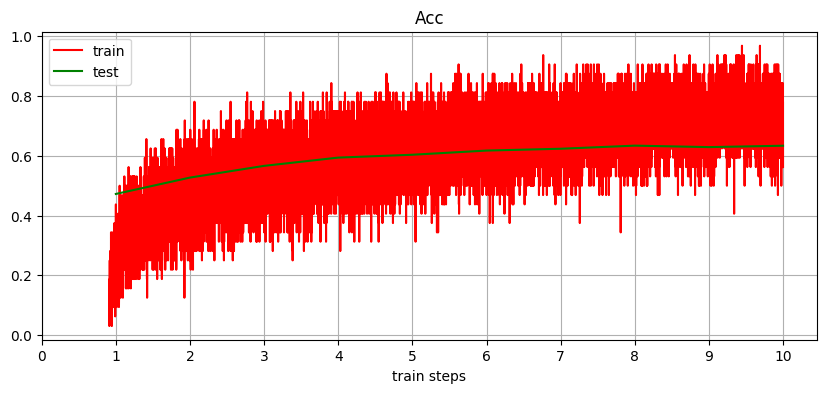

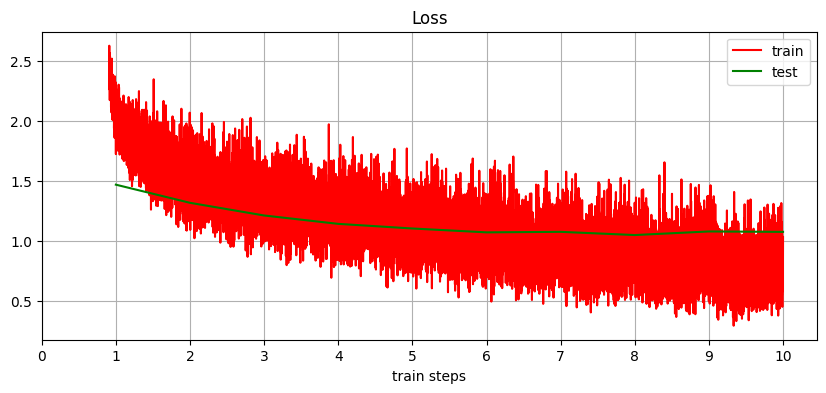

Final Accuracy = 63.39%
Final Loss = 1.07
CPU times: user 2min 46s, sys: 15 s, total: 3min 1s
Wall time: 7min 19s


In [47]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

model = ModelCNN()
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_acc_log, val_loss_log = train(model, opt, 10, loader_train, loader_test)

## Вывод

Использована метрика accuracy так как классы сбалансированы и проблем с accuracy нет. Использована сверточная модель с 6-ю слоями свертки и 2 линейными полносвязными слоями. В целом, качество получилось не вау, возможно можно добавить больше слоев, dropout, maxpooling и провести больше экспериментов.

Будьте готовы ответить на любые вопросы по коду, процессу обучения, моделям и метрикам.